# Week 1: Text Classification - Mike Ion

### What are we building
We’ll continue to apply our learning philosophy of repetition as we build multiple classification models of increasing complexity in the following order:

1. Average of Word2Vec + MLP Layer
1. Can we concatenate 3 token embeddings and then average them? Does this do better than the previous method?
1. Build an embedding layer based model.
1. **Extension**: Explore different parameters, features and architectures.

###  Evaluation
We’ll be evaluating our models on the following metric:

1. Accuracy: is the ratio of the number of correctly classified instances to the total number of instances
1. **Extension**: this is a multi-class classification problem, visualize a [confusion matrix](https://torchmetrics.readthedocs.io/en/stable/classification/confusion_matrix.html?highlight=confusion%20matrix) of N*N of actual class vs predicted class (N = number of classes).


### Instructions

1. We've provide scaffolding for all the boiler plate PyTorch code to get to our first model. This covers downloading and parsing the dataset, training code for the baseline model. **Make sure to read all the steps and internalize what is happening**.
1. At this point our model gets to an accuracy of about 0.32. After this we'll try to improve the model by using sliding windows of text instead of just one word at a time. **Does this improve accuracy?**
1. The third model we're going to build is an embedding layer based model. Here instead of using pre-trained word-embeddings we'll be creating new vectors as part of the training process. **How do you think this model will perform?**
1. **Extension**: We've suggested a bunch of extensions to the project so go crazy, tweak any parts of the pipeline and see if you can beat all the current models.

### Code Overview
- Dependencies: Python dependencies and loading the spacy model
- Project
  - Dataset: Download the conversation dataset and parse it into a pytorch Dataset
  - Trainer: Trainer function to help with multi-epoch training
  - Model 1: Simple Word2Vec + MLP model
  - Model 2: Sliding window trigram (Word2Vec)
  - Model 3: Embedding bag based model on Trigram
- Extensions



# Dependencies

✨ Now let's get started and to kick things off as always we install some dependencies.

In [ ]:
%%capture
# Install all the required dependencies for the project
!pip install pytorch-lightning==1.6.5 spacy==2.2.4
!python -m spacy download en_core_web_md

Import all the necessary libraries we need throughout the project.

One of the critical modules we are importing below is torch.utils.data, and I want to provide some notes here to talk about this for future reference.

torch.utils.data provides a set of classes for creating and managing datasets in PyTorch (e.g., Dataset, Subset) as well as utilities for splitting data into train and test sets (e.g., random_split).

`Dataset` is an abstract class that represents a dataset. It provides two methods: __len__, which should return the number of samples in the dataset, and __getitem__, which should return a single sample at a given index. Ankit went over the __getitem__

`DataLoader` is a class that provides an iterator interface for iterating over a dataset in batches. It automatically handles batching, shuffling, and parallel data loading (with the `num_workers` parameter).

`torch.nn.utils.data.random_split` splits a dataset into two new datasets for training and validation. It takes in a Dataset object and a list of split ratios (which should add up to 1.0), and returns two new Dataset objects that have been split randomly based on the specified ratios.

In [ ]:
!pip install torchmetrics pytorch-lightning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 721.2/721.2 kB 14.4 MB/s eta 0:00:00


In [ ]:
# sklearn.preprocessing.LabelEncoder provides a way to encode categorical features
# as numeric values. It can be used to convert string labels into integers.
# For example, if we wanted to convert our the labels we have put on each dialogue from
# labels = ['sentimental', 'sentimental', 'afraid', 'proud', 'terrified', 'afraid', ..., 'joyful']
# to a list of numeric features, [1 1 2 3 4 2 ... 5], we create a LabelEncoder object,
# le = LabelEncoder(), and apply fit_transform() to the list of labels.
from sklearn.preprocessing import LabelEncoder

# torch.nn provides some building blocks for building neural networks,
# including layers (embedding, convolutional, dropout/regularization),
# activation functions, loss functions, optimizers, transforms.
from torch import nn
# Really important one -- torch.nn.utils.rnn.pad_sequence provides a
# function for padding batches of sequences to be a common length.
# A critical element in this NN work -- making sure to the dimensionality
# of these matrices line up to do the matrix multiplication operations.
from torch.nn.utils.rnn import pad_sequence
# torch.utils.data
from torch.utils.data import DataLoader, Dataset, random_split
import torch
import torch.nn.functional as F
import torchmetrics
from torchmetrics.functional.classification import multiclass_confusion_matrix

# en_core_web_md is a pre-trained English language model (trained on 20k words) from spaCy.
# It is loaded in with spacy.load function and it provides pre-trained word-vectors,
# has capacity for NER, POS tagging, dependency parsing, tokenization/lemmatization.
# There is also a lightweight, speedier version: en_core_web_sm (10k words)
import en_core_web_md
# spacy is one of many popular NLP libraries that provides many pre-trained language models
# in many languages. Additionally, it provides the set of utilities for tokenization, NER,
# etc. for language models like en_core_web_md.
import spacy

# pytorch_lightning is a Python library that provides a lightweight interface for working with PyTorch,
# which is a popular open-source machine learning framework. It is designed to simplify the process of
# training complex models by providing a range of useful abstractions and pre-built components that can be easily combined to create custom models.
import pytorch_lightning as pl


import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

First things first, let's load the Spacy data which comes with pre-trainined embeddings. This process is expensive so only do this once.

In [ ]:
# Really expensive operation to load the entire space word-vector index in memory
# We'll only run it once
loaded_spacy_model = en_core_web_md.load()

Fix the random seed for numpy and pytorch so the entire class gets consistent results which we can discuss with each other.

In [ ]:
# Fix the random seed so that we get consistent results
torch.manual_seed(0)
np.random.seed(0)

# Classifier Project

✨ Let's Begin ✨

### Data Loading and Processing (Common to ALL Solutions)

#### Dataset

We’ll be using the Empathetic Dialogs dataset open-sourced by Facebook ([link](https://research.fb.com/publications/towards-empathetic-open-domain-conversation-models-a-new-benchmark-and-dataset/)). It can be downloaded as a tar ball from the following [link](https://dl.fbaipublicfiles.com/parlai/empatheticdialogues/empatheticdialogues.tar.gz)

A sample row from the dataset:
```
conv_id,utterance_idx,context,prompt,speaker_idx,utterance,selfeval,tags
hit:12388_conv:24777,1,joyful,I felt overcome with emotions when Christmas came around as a kid,437,Christmas was the best time of year back in the day!,5|5|5_5|5|5, ''
```

The three columns we'll primarily focus on are:
1. context ==> emotion we're trying to predict
1. prompt + utterance ==> We'll combine these sentences and use them as input

But let's download and explore the dataset and these should automatically get clear.


In [ ]:
import tarfile
import os
import csv

DIRECTORY_NAME="classification"
TRAIN_FILE="classification/empatheticdialogues/train.csv"
VALIDATION_FILE="classification/empatheticdialogues/valid.csv"
TEST_FILE="classification/empatheticdialogues/test.csv"


def download_dataset():
  """
  Download the dialog dataset. The tarball contains three files: train.csv, valid.csv, test.csv
  """
  !wget 'https://dl.fbaipublicfiles.com/parlai/empatheticdialogues/empatheticdialogues.tar.gz'
  if not os.path.isdir(DIRECTORY_NAME):
    !mkdir classification
  tar = tarfile.open('empatheticdialogues.tar.gz')
  tar.extractall(DIRECTORY_NAME)
  tar.close()

# Expensive operation so we should just do this once
download_dataset()

--2023-07-02 04:17:53--  https://dl.fbaipublicfiles.com/parlai/empatheticdialogues/empatheticdialogues.tar.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.225.142.88, 13.225.142.90, 13.225.142.76, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|13.225.142.88|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 28022709 (27M) [application/gzip]
Saving to: ‘empatheticdialogues.tar.gz.1’

empatheticdialogues 100%[===================>]  26.72M  80.1MB/s    in 0.3s    

2023-07-02 04:17:53 (80.1 MB/s) - ‘empatheticdialogues.tar.gz.1’ saved [28022709/28022709]



Now the question is that did it do the right thing? Time to find out.


In [ ]:
import glob
glob.glob(f"{DIRECTORY_NAME}/**/*.csv", recursive=True)

['classification/empatheticdialogues/test.csv',
 'classification/empatheticdialogues/valid.csv',
 'classification/empatheticdialogues/train.csv']

Cool we see all our files. Let's poke at one of them before we start parsing our dataset.

In [ ]:
# See the parse_dataset function below for short explanation.
df = pd.read_csv(TRAIN_FILE, sep='\n', header=None)
df[0].str

ValueError: ignored

In [ ]:
# See the parse_dataset function below for short explanation.
df = pd.read_csv(TRAIN_FILE, sep='\n', header=None)
df = df[0].str.split(',', expand=True)
new_header = df.iloc[0]
df = df[1:]
df.columns = new_header
df.head(5)

,conv_id,utterance_idx,context,prompt,speaker_idx,utterance,selfeval,tags
1,hit:0_conv:1,1,sentimental,I remember going to the fireworks with my best...,1,I remember going to see the fireworks with my ...,5|5|5_2|2|5,
2,hit:0_conv:1,2,sentimental,I remember going to the fireworks with my best...,0,Was this a friend you were in love with_comma_...,5|5|5_2|2|5,
3,hit:0_conv:1,3,sentimental,I remember going to the fireworks with my best...,1,This was a best friend. I miss her.,5|5|5_2|2|5,
4,hit:0_conv:1,4,sentimental,I remember going to the fireworks with my best...,0,Where has she gone?,5|5|5_2|2|5,
5,hit:0_conv:1,5,sentimental,I remember going to the fireworks with my best...,1,We no longer talk.,5|5|5_2|2|5,


The set of columns we care about are:
1. context ==> emotion we're trying to predict
1. prompt + utterance ==> We'll combine these sentences and use them as input

Let's create a label encoder which converts our text labels to integer ids or vice versa

In [ ]:
label_to_integer = dict()
integer_to_label = dict()

for ix, label in enumerate(df["context"].unique()):
  label_to_integer[label] = ix
  integer_to_label[ix] = label

Parse the dataset file and create a label encoder that converts text labels to integer ids or vice versa

In [ ]:
def parse_dataset(file_path, sample=5000):
  # Our dataset file is a csv with varying input lengths, therefore we load the
  # file at once, we have to split it up into separate steps:
  # 1. Read each row as a single column row
  df = pd.read_csv(file_path, sep = '\n', header = None)
  # 2. Split up each row into separate columns
  df = df[0].str.split(',', expand = True)
  # 3. Set the header by using the first row
  new_header = df.iloc[0]
  df = df[1:]
  df.columns = new_header

  # Machine learning cannot work with categorical labels like "suprised" or
  # "excited". Therefore we convert these tokens into a number.
  df["target"] = df["context"].apply(lambda x: label_to_integer[x])
  df["feature"] = df["prompt"] + " " + df["utterance"]

  # We only need the column "**feature**" created from column
  # "**prompt**" + "**utterance**" and the column "**target**".
  return df[["target", "feature"]].sample(n = sample, random_state = 0).values

Creating the global training, validation and test datasets from the data files. We've limited our sample size to speed up the training of the models. Originally these are the sizes of the dataset:

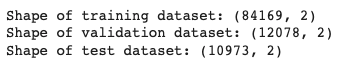

In [ ]:
# Total sample size is 107,220.

training_data = parse_dataset(TRAIN_FILE, sample = 40000)
validation_data = parse_dataset(VALIDATION_FILE, sample = 4000)
test_data = parse_dataset(TEST_FILE, sample = 4000)

print('Shape of training dataset: ({rows}, {cols})'.format(rows=len(training_data), cols=len(training_data[0])))
print('Shape of validation dataset: ({rows}, {cols})'.format(rows=len(validation_data), cols=len(validation_data[0])))
print('Shape of test dataset: ({rows}, {cols})'.format(rows=len(test_data), cols=len(test_data[0])))

Shape of training dataset: (40000, 2)
Shape of validation dataset: (4000, 2)
Shape of test dataset: (4000, 2)


[Dataset and Data loaders](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html): Code for processing data samples can get messy and hard to maintain; we ideally want our dataset code to be decoupled from our model training code for better readability and modularity. PyTorch provides two data primitives: torch.utils.data.DataLoader and torch.utils.data.Dataset that allow you to use pre-loaded datasets as well as your own data. Dataset stores the samples and their corresponding labels, and DataLoader wraps an iterable around the Dataset to enable easy access to the samples.

[LightingDataModule](https://pytorch-lightning.readthedocs.io/en/latest/extensions/datamodules.html#datamodules): A datamodule is a shareable, reusable class that encapsulates all the steps needed to process data. A datamodule encapsulates the five steps involved in data processing in PyTorch:

1. Download / tokenize / process.
2. Clean and (maybe) save to disk.
3. Load inside Dataset.
4. Apply transforms (rotate, tokenize, etc…).
5. Wrap inside a DataLoader.

## A bit more on Pytorch Lightning

In essence, Pytorch Lightning is nothing more than more organized Pytorch code. This [Youtube video](https://www.youtube.com/watch?v=Hgg8Xy6IRig) by Patrick Loeber provided a nice introduction to some of its main benefits. Specifically, you **no longer have to worry about**:
- When to set your model to training and evaluation mode
- Using a "device" for gpu support, and the line of code for pushing your model to device
- Pytorch Lightning makes it easier to scale models across several GPUs/TPUs
- Calling zero_grad or step on the optimizer, as well as calling backward on the loss
- Using torch.no_grad or need to use .detach()
- Integrated tensorboard support

As we see throughout our code, Pytorch Lightning has a built-in ModelSummary callback, that can be used to print a summary of the model's architecture, number of traininable parameters, size of the trainable parameters, and performance of the model.

This homework assignment provided some insight on how Pytorch Lighning module classes can provide united interfaces for configuring and training models, without having to specify specific implementation details about the model. For example, in terms of this classification task we are able to define ClassificationDataset and EmotionClassifier, set them up a priori, and then use them in a variety of different models.


In [ ]:
# The ClassificationDataset class is a PyTorch Dataset that is designed to consume pre-loaded datasets
# for use in a classification task. According to the documentation, when we want to create a custom
# Dataset Class, the class must implement three functions: __init__, __len__, and __getitem__.
# It takes two arguments: a data object and a vectorizer object.

class ClassificationDataset(Dataset):
  """Creates an pytorch dataset to consume our pre-loaded csv data

  Reference: https://pytorch.org/tutorials/beginner/basics/data_tutorial.html
  """
  # This initializes a new instance of the class. Important to note here that
  # `data` is a dataset that has already been pre-processed and loaded into
  # memory (e.g., in tuples), Each tuple represents a single example in the dataset, and contains the label (e.g., a class or category) and the input data (e.g., a text string or sequence of tokens).
  def __init__(self, data, vectorizer):
    self.dataset = data
    # Vectorizer needs to implement a vectorize function that returns vector and tokens
    # 🌟🌟🌟 Pay extra attention here since you'll have to work on this in the models 🌟🌟🌟
    self.vectorizer = vectorizer

  def __len__(self):
    return len(self.dataset)

  # __getitem__ is defined to return a single sample from the dataset at the
  # specified index idx. The method takes in an index as an argument, and
  # returns a dictionary containing the data for the sample, including the
  # label, vectorized sentence, and tokens.
  def __getitem__(self, idx):
    (label, sentence) = self.dataset[idx]
    sentence_vector, sentence_tokens = self.vectorizer.vectorize(sentence)
    return {
        "vectors": sentence_vector,
        "label": label,
        "tokens": sentence_tokens, # for debugging only
        "sentence": sentence # for debugging only
      }


# The LightningModule class serves as a wrapper around a standard PyTorch model, and
# provides several methods for common tasks such as training, validation, and
# testing, as well as automatic handling of things like logging, saving and loading of checkpoints,
# and distributed training.

# The purpose of using ClassificationDataModule here is to wrap our dataset; that is,
# define three datasets (classification_train, classification_val, and classification_test) that are created using the
# ClassificationDataset class, inherited from pl.LightningDataModule. ClassificationDataset takes in our raw input data,
# along with a vectorizer object that can convert the raw data into a format that can be used for training our classification model.
class ClassificationDataModule(pl.LightningDataModule):
  """LightningDataModule: Wrapper class for the dataset to be used in training
  """
  def __init__(self, vectorizer, params):
    super().__init__()
    self.params = params
    self.classification_train = ClassificationDataset(training_data, vectorizer)
    self.classification_val = ClassificationDataset(validation_data, vectorizer)
    self.classification_test = ClassificationDataset(test_data, vectorizer)

  # Function to convert the input raw data from the dataset into model input.
  # 🌟🌟🌟 Pay extra attention here since you'll have to work on this in the models 🌟🌟🌟


  # This is function that gets called by the dataloader to collate the sentences into batches
  # of sentences.

  def collate_fn(self, batch):
    # Embedding layers need the inputs to be integer so we need to add this special case here.
    if self.params.integer_input:
      word_vector = [torch.LongTensor(item["vectors"]) for item in batch]
      sentence_vector = pad_sequence(word_vector, batch_first=True, padding_value=0)
    else:
      sentence_vector = torch.stack([torch.Tensor(item["vectors"]) for item in batch])
    labels = torch.LongTensor([item["label"] for item in batch])
    return {"vectors": sentence_vector, "labels": labels, "sentences": [item["sentence"] for item in batch]}

  # Training dataloader .. will reset itself each epoch
  def train_dataloader(self):
    return DataLoader(self.classification_train, batch_size=self.params.batch_size, collate_fn=self.collate_fn)

  # Validation dataloader .. will reset itself each epoch
  def val_dataloader(self):
    return DataLoader(self.classification_val, batch_size=self.params.batch_size, collate_fn=self.collate_fn)

  # Test dataloader .. will reset itself each epoch
  def test_dataloader(self):
    return DataLoader(self.classification_test, batch_size=self.params.batch_size, collate_fn=self.collate_fn)

### Classfier and Trainer (Common to all solutions)

We've now created the DataLoader and Datasets we'll use in the entire project.It is time to write the training and testing loops.

[LightingModule](https://pytorch-lightning.readthedocs.io/en/latest/common/lightning_module.html): organizes your PyTorch code into 5 sections

1. Computations (init).
2. Train loop (training_step)
3. Validation loop (validation_step)
4. Test loop (test_step)
5. Optimizers (configure_optimizers)

In [ ]:
"""Mike - note to self: one of two of the most important cells in this notebook. This class
defines a Pytorch Lightning module for the task of training, validating, testing (and then,
could be used to predict on out of sample data). It takes in a model as well as a params
object during its initialization, and defines 6 important methods. See here for more details:
https://pytorch-lightning.readthedocs.io/en/latest/common/lightning_module.html

1. forward(self, x):
  input: a tensor x.
  output: passes through the model
2. training_step(self, batch, batch_idx)
  input: Batch is a dictionary that contains input data and true labels. Batch_idx simply provides
  an running count of number of batches that have been processed during the current epoch (isn't used
  in the computation of the loss), but shows up in the progress bar (looks like we can play around
  customizing the display of the logs:
  https://pytorch-lightning.readthedocs.io/en/latest/visualize/logging_advanced.html?highlight=batch_idx)
  output: Returns the loss using F.cross_entropy function(), by taking predicted class probabilities y_hat
  and the true labels y. By setting the reduction parameter to 'mean', this means the loss is averaged
  across the batch.
3. validation_step(self, batch, batch_nb)
  Same exact implementation as above, but with a slight change in convention with how we represent our batch ids.
  I'm assuming idx means index and nb refers to number. So while it doesn't really matter what we call these indices,
  it is helpful to distinguish them as it seems the rule for convention here is to use:
  - idx when we want to repesent the index of a particular element in our dataset or in a tensor (for example, when we
  use idx as as index in __getitem__ to return a single sample).
  - nb when we want to represent a count (like in an iterator, in order to see our progress).
  I'm not going to change the code for this boilerplate code, but if I were to write the code for this class from scratch, I
  think best practice would maybe to be to change batch_idx in training_step to be batch_nb.
4. test_step(self, batch, batch_nb)
  Same as above.
5. predict_step(self, batch, batch_idx)
  input: A batch of data, and its particular index value (batch_idx), defined as above
  output: A data tensor x, is extracted from the batch using the key 'vectors' (from collate_fn), and y-hat, a tensor of possible
  class probabilities for the tensor is predicted by passing it through the model. The predicted class for the input tensor is put
  into a new tensor, predictions, containing the indices of the maximum values in each row of y-hat. Then, the function returns a dictionary
  containing the predicted logits (y-hat), the predictions tensor, as well as the text of the true label and the sentences.
6. configure_optimizers(self)
  input: This defines the optimizer for the model. This is a really cool part of seeing Pytorch Lightning for me, the fact that we call
  torch.optim.Adam() on the models parameters (when you call .parameters() on a model, Pytorch returns an iterator over all the trainable
  parameters in the model, including any parameters within sub-modules: https://pytorch.org/docs/stable/generated/torch.nn.Module.html?highlight=parameters#torch.nn.Module.parameters).
  Details on the Adam optimizer are here, the pseudocode is actually quite nice: https://pytorch.org/docs/stable/generated/torch.optim.Adam.html?highlight=optim+adam#torch.optim.Adam
  With some optimizers and vanilla Pytorch, we usually have to write a line of code that does the "step" process (subtracting a fraction of the gradient of the loss function
  from the current value of the parameters), and then another line of code to set all of the gradients of the model parameters to zero before we do another training loop; however,
  here it's all built in.

"""

# 🌟🌟🌟 Pay extra attention here since you'll have to work on this in the models 🌟🌟🌟
class EmotionClassifier(pl.LightningModule):
  def __init__(self, model, params):
      super().__init__()
      self.model = model
      self.params = params
      # This further establishes that we are working on a multiclass classification problem
      # (rather than 'binary', or 'multilabel'), and that the set of classes to choose from
      # must be set in the params object in num_classes
      self.accuracy = torchmetrics.Accuracy(task='multiclass', num_classes=params.num_classes)


  def forward(self, x):
      return self.model(x)

  def training_step(self, batch, batch_idx):
    x = batch["vectors"]
    y = batch["labels"]
    y_hat = self(x)
    loss = F.cross_entropy(y_hat, y, reduction='mean')
    self.log_dict(
        {'train_loss': loss},
        batch_size=self.params.batch_size,
        prog_bar=True
        )
    return loss

  def validation_step(self, batch, batch_nb):
    x = batch["vectors"]
    y = batch["labels"]
    y_hat = self(x)
    val_loss = F.cross_entropy(y_hat, y, reduction='mean')
    predictions = torch.argmax(y_hat, dim=1)
    self.log_dict(
        {
          'val_loss': val_loss,
          'val_accuracy': self.accuracy(predictions, y)
        },
        batch_size=self.params.batch_size,
        prog_bar=True
      )
    return val_loss

  def test_step(self, batch, batch_nb):
    x = batch["vectors"]
    y = batch["labels"]
    y_hat = self(x)
    test_loss = F.cross_entropy(y_hat, y, reduction='mean')
    predictions = torch.argmax(y_hat, dim=1)
    self.log_dict(
        {
          'test_loss': test_loss,
          'test_accuracy': self.accuracy(predictions, y)
        },
        batch_size=self.params.batch_size,
        prog_bar=True
      )
    return test_loss

  def predict_step(self, batch, batch_idx):
    y_hat = self.model(batch["vectors"])
    predictions = torch.argmax(y_hat, dim=1)
    return {'logits':y_hat, 'predictions': predictions, 'labels': batch["labels"], 'sentences': batch['sentences']}

  def configure_optimizers(self):
    optimizer = torch.optim.Adam(self.parameters(), lr=self.params.learning_rate)
    return optimizer

Once we have a Lightning and LightingDataModule, a [Trainer](https://pytorch-lightning.readthedocs.io/en/latest/common/trainer.html) automates everything else. It provides functions for training (fit), testing and inference. We ended up writing a helper function that takes the model, vectorizer and hyper parameters to be able to easily compare our different models.

In [ ]:
def trainer(model, params, vectorizer):
  # Create a pytorch trainer
  # Note, you need to put these first two options in the Trainer in order to use Colab's GPUs, even if you change your runtime type.
  trainer = pl.Trainer(accelerator='gpu', devices=1, max_epochs=params.max_epochs, check_val_every_n_epoch=1)

  # Initialize our data loader with the passed vectorizer
  data_module = ClassificationDataModule(vectorizer, params)

  # Instantiate a new model
  model = EmotionClassifier(model, params)

  # Train and validate the model
  trainer.fit(model, data_module.train_dataloader(), val_dataloaders=data_module.val_dataloader())

  # Test the model
  trainer.test(model, data_module.test_dataloader())

  # Predict on the same test set to show some output
  output = trainer.predict(model, data_module.test_dataloader())

  # This is for the confusion matrix at the end - rather than re-run the code, throw the true_labels,
  # and the predicted_labels into a cm object every time we run this function.

  true_labels = []
  predicted_labels = []
  for o in output:
    true_labels.append(o['labels'])
    predicted_labels.append(o['predictions'])
  true_labels = torch.cat(true_labels, dim=0)
  predicted_labels = torch.cat(predicted_labels, dim=0)

  cm = multiclass_confusion_matrix(predicted_labels, true_labels, num_classes=params.num_classes)

  for i in range(2):
    print("-----------")
    print("Sentence: ", output[1]['sentences'][i])
    print("Predicted Emotion: ", integer_to_label[output[1]['predictions'][i].item()])
    print("Actual Label: ", integer_to_label[output[1]['labels'][i].item()])

  return trainer, model, cm




# Models

Are we building models yet? Finally the time has come to build our baseline model and then we'll work towards improving it.

### Model 1: Average word vector of the sentence -- Baseline
##### <font color='red'>Expected accuracy: ~29 - 32%</font>

Let's build our first simple word2vec based model we'll use as our baseline.

Here we've three key pieces:

1. *WordVectorClassificationModel*: Simple linear model that just has one single neuron layer that maps the input word2vec dimensions (300) to the output classes (32) building a really simple classifier.

In [ ]:
class WordVectorClassificationModel(torch.nn.Module):
  def __init__(self, word_vec_dimension, num_classes):
    super().__init__()
    self.classes = num_classes
    self.linear_layer = torch.nn.Linear(word_vec_dimension, num_classes)

  # 🌟🌟🌟 Pay extra attention here since you'll have to work on this in the models 🌟🌟🌟
  def forward(self, batch):
    """Projection from word_vec_dim to n_classes

    Batch is of shape (batch_size, max_seq_len, word_vector_dim)
    """
    return self.linear_layer(batch)

2. *HParams*: a class that contains all the hyper parameters relevant for the current model.
3. *SpacyVectorizer*: Vectorizer that converts the text sentence into the input to the DataLoader's collate function. Basically we'll call vectorizer on each row of the input data and then call the collate_fn on each batch of items which is fed to the Neural Network.

It will take several minutes to train the model, so don't be alarmed if you don't get the result right away. When the cell finishes running, under the `DATALOADER:0 TEST RESULTS` section, you should see the `test_accuracy` field with a value of ~0.3.

In [ ]:
class HParams:
  batch_size: int = 32
  integer_input: bool = False
  word_vec_dimension: int = 300
  num_classes: int = 32
  learning_rate: float = 0.001
  max_epochs: int = 4


# 🌟🌟🌟 Pay extra attention here since you'll have to work on this in the models 🌟🌟🌟
class SpacyVectorizer:
  def vectorize(self, sentence):
    """
    Given a sentence, tokenize it and reference pre-trained word vector for each token.

    Returns a tuple of sentence_vector and list of text tokens
    """
    sentence_vector = []
    sentence_tokens = []
    spacy_doc = loaded_spacy_model.make_doc(sentence) ## I am Mike
    word_vectors = [token.vector for token in spacy_doc] ## [ [Embedding of I], [Embedding of am], [Embedding of UNK]]
    sentence_tokens = list([token.text for token in spacy_doc])

    sentence_vector = np.mean(np.array(word_vectors), axis=0)
    return sentence_vector, sentence_tokens

trainer(model=WordVectorClassificationModel(HParams.word_vec_dimension,
                                            HParams.num_classes),
        params=HParams,
        vectorizer=SpacyVectorizer())

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True, used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name     | Type                          | Params
-----------------------------------------------------------
0 | model    | WordVectorClassificationModel | 9.6 K 
1 | accuracy | MulticlassAccuracy            | 0     
-----------------------------------------------------------
9.6 K     Trainable params
0         Non-trainable params
9.6 K     Total params
0.039     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy         0.3267500102519989
        test_loss            2.456451654434204
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Predicting: 1250it [00:00, ?it/s]

-----------
Sentence:  When I got falsely accused of eating my roommate's ice cream last night_comma_ I was completely outraged! I don't even eat ice cream because I'm lactose intolerant_comma_ and she knows that! I wonder who actually ate it then.
Predicted Emotion:  guilty
Actual Label:  furious
-----------
Sentence:  I found out that my childhood cat passed away yesterday  Thats sad. I love cats
Predicted Emotion:  sad
Actual Label:  sad


(<pytorch_lightning.trainer.trainer.Trainer at 0x7f44e5d67e20>,
 EmotionClassifier(
   (model): WordVectorClassificationModel(
     (linear_layer): Linear(in_features=300, out_features=32, bias=True)
   )
   (accuracy): MulticlassAccuracy()
 ),
 tensor([[35,  2,  1,  ...,  2,  0,  7],
         [ 1, 37,  0,  ...,  0,  0,  3],
         [ 2,  0, 65,  ..., 15,  0,  0],
         ...,
         [ 0,  2,  8,  ..., 51,  0,  0],
         [ 0, 12,  1,  ...,  0,  3,  3],
         [ 0,  0,  1,  ...,  1,  0, 40]]))

🎉🎉🎉 WE HAVE OUR TEXT CLASSIFIER 🎉🎉🎉


Now might be a good time to play around with the vectorizer and the classifier.

### Assignment Part: 1 - Model 2: Sliding Window Word2Vec ---- TO BE COMPLETED
##### <font color='red'>Expected accuracy: ~30 to 36%</font>

We'll be re-using the simple linear model from Model-1 but changing the input to use sliding windows instead of one word at a time.

Implement a new `SpacyChunkVectorizer` which is a variant of the `SpacyVectorizer` that operates. Here are some instructions on how to implement it.

1. Split the sentence into chunks of the size of the n_grams parameter.
2. Concat all the spacy embeddings of the tokens inside to create embeddings of the chuck. Each chunk vector is of the size of `3 * size_of_embedding`
3. Sentence vector is the average of all chunk vectors.
4. Return the sentence_vector and tokens (for debugging, option: could just return None for tokens)

Does this model perform better than our baseline? Why do you think that is?

In [ ]:
class HParamsSpacy:
  batch_size: int = 32
  integer_input: bool = False
  word_vec_dimension: int = 300
  num_classes: int = 32
  learning_rate: float = 0.001
  max_epochs: int = 4
  n_grams: int = 3


class SpacyChunkVectorizer:
  def __init__(self, params):
    self.params = params

  def vectorize(self, sentence):
    """
    Given a sentence, tokenize it and returns a word vector for that sentence.

    Sentence is of length (n)

    1. Split the sentence into tokens using Spacy's function make_doc
    2. Split the list of token into size of the n_grams parameter.
    3. Concat all the spacy embeddings of the tokens inside to create embeddings of the chunk. Each chunk vector is of the size of 3 * size_of_embedding
    4. Sentence vector is the average of all chunk vectors.
    5. Return the sentence_vector and tokens (option: could just return None for tokens)

    Sentence_vector is of length (n_grams * word_vector_dim)
    Sentence_tokens is of length (n)

    Example of word tri-gram encoding: "I am doing great right now.":
      <EMPTY (300,)> <EMPTY (300,)> <I (300,)> -> (900, )
      <EMPTY (300,)> <I (300,)> <am (300,)> -> (900, )
      <I (300,)> <am (300,)> <doing (300,)> -> (900, )
      <am (300,)> <doing (300,)> <great (300,)> -> (900, )
      <doing (300,)> <great (300,)> <right (300,)> -> (900, )
      <great (300,)> <right (300,)> <now (300,)> -> (900, )
      <right (300,)> <now (300,)> <EMPTY (300,)> -> (900, )
      <now (300,)> <EMPTY (300,)> <EMPTY (300,)> -> (900, )

    We'd encourage you to also try other variants to encode!
    """

    sentence_tokens = []
    all_chunks = []

    # Step 1. Convert the sentence from a text string to a `Doc` object
    # the primary data structure used by spacy to represent documents.
    spacy_doc = loaded_spacy_model.make_doc(sentence)

    # This loop iterates through each word of the sentence, all
    # the way up until the word that reaches the last window length
    # determined by the window size set in the n_grams parameter of the
    # HParamsSpacy class.
    for i in range(len(spacy_doc) - HParamsSpacy.n_grams + 1):
      # Step 2. Chop off chunk of sentence at word i of window size `n_gram`
      chunk = spacy_doc[i: i+HParamsSpacy.n_grams]
      # Step 3. Concatenate the spacy embeddings of each token in the window
      chunk_vector = torch.cat([torch.tensor(token.vector, dtype=torch.float32) for token in chunk])
      all_chunks.append(chunk_vector)
      sentence_tokens = list([token.text for token in spacy_doc])

    # Create a sentence embedding vector by looking through two cases:
    # 1. if all_chunks isn't empty, take the mean of all the chunks in all_chunks
    # Each chunk is a 900-dimensional column vector, so to take a mean of all of these
    # chunks means to take a mean across rows, (dim=0)

    if all_chunks:
      sentence_vector = torch.stack(all_chunks, dim=0).mean(dim=0)
    else:
      sentence_vector = torch.zeros(HParamsSpacy.n_grams * HParamsSpacy.word_vec_dimension, dtype=torch.float32)

    return sentence_vector, sentence_tokens

trainer(
    model=WordVectorClassificationModel(
        # Observe the change in input parameters
        HParamsSpacy.word_vec_dimension * HParamsSpacy.n_grams,
        HParamsSpacy.num_classes),
    params=HParamsSpacy,
    vectorizer=SpacyChunkVectorizer(HParamsSpacy))

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True, used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name     | Type                          | Params
-----------------------------------------------------------
0 | model    | WordVectorClassificationModel | 28.8 K
1 | accuracy | MulticlassAccuracy            | 0     
-----------------------------------------------------------
28.8 K    Trainable params
0         Non-trainable params
28.8 K    Total params
0.115     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy         0.36250001192092896
        test_loss           2.2151527404785156
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Predicting: 1250it [00:00, ?it/s]

-----------
Sentence:  When I got falsely accused of eating my roommate's ice cream last night_comma_ I was completely outraged! I don't even eat ice cream because I'm lactose intolerant_comma_ and she knows that! I wonder who actually ate it then.
Predicted Emotion:  ashamed
Actual Label:  furious
-----------
Sentence:  I found out that my childhood cat passed away yesterday  Thats sad. I love cats
Predicted Emotion:  sad
Actual Label:  sad


(<pytorch_lightning.trainer.trainer.Trainer at 0x7f44ea91fee0>,
 EmotionClassifier(
   (model): WordVectorClassificationModel(
     (linear_layer): Linear(in_features=900, out_features=32, bias=True)
   )
   (accuracy): MulticlassAccuracy()
 ),
 tensor([[45,  3,  1,  ...,  3,  0, 10],
         [ 1, 52,  0,  ...,  1,  1,  5],
         [ 2,  0, 58,  ..., 26,  0,  0],
         ...,
         [ 0,  1,  2,  ..., 74,  2,  0],
         [ 0, 14,  1,  ...,  0, 15,  2],
         [ 0,  2,  0,  ...,  1,  2, 49]]))

## Reflection on Model 2

The sliding windows performed better! This is likely because the sliding windows allowed the model to capture some of the context around each word in the sentence, rather than looking at words in isolation. Additionally, sliding windows handle out-of-vocabulary words better than using token embeddings.

### Assignment Part: 2 - Model 3: EmbeddingBag  ---- TO BE COMPLETED
##### <font color='red'>Expected accuracy: ~32 to 38%</font>

The third model we're going to build is an embedding layer based model. Here instead of using pre-trained word-embeddings we'll be creating new vectors as part of the training process. How do you think this model will perform?

Implementation has the following steps:

1. **`get_char_trigram_token_map`**: Implement a map that returns top `num_tokens` token in the corpus to some allocated ids between `1 to num_tokens`. Here are some steps that should help with the implementation.
      1. Compute a frequency map of the `num_tokens` most common  character trigrams in the training data. **Note: We're now moving away from words and moving to just using characters directly**.
      3. Create unique integer ids for all these tokens 1...N

2. **Vectorizer**: Implement a new vectorizer for each sentence that does the following:
    1. Get all trigrams for the sentence
    2. Get id for every trigram
    4. Append all the ids into a list and that is your sentence vector

3. **Forward pass of the model**: Implement the forward pass of the model
    1. Pass the input batch through the embedding layer
    1. Pass the output of the embedding layer into our linear layer  


Some rational for trying this out is:
- We average the embeddings in a sentence anyway so word or not word maybe doesn't matter.
- Vocabalary of character trigrams is much smaller than word trigrams so our models are easier to train.

In [ ]:
class HParamsCTT:
  batch_size: int = 16  ### NOTE THE CHANGE
  integer_input: bool = True  ### NOTE THE CHANGE
  num_classes: int = 32
  learning_rate: float = 0.001
  max_epochs: int = 4
  n_grams: int = 3
  embed_dim: int = 350 # ADDED, Change it to your liking
  num_tokens: int = 5000
  hidden_dim: int = 265


class CharacterTrigramTokenizer:
  """
  We represent a sentence as a vector of num_tokens tokens.
  If the trigram is present in the sentence then we add the token's id to the sentence

  Mike: note to self -- character trigrams (or numbers, punctuation, any combination of characters....)
  are considered individual tokens too! A token is just a sequence of characters that we assign to have
  a 'unit' of meaning. This exercise is a good re-emphasis of that idea.
  """
  def __init__(self, train_data, num_tokens):
    self.num_tokens = num_tokens
    self.token_to_id_map = self.get_char_trigram_token_map(train_data, num_tokens)


  def get_char_trigram_token_map(self, train_data, num_tokens):
    """
    1. Compute a frequency map of the `num_tokens` most common character trigrams in the training data.
    2. Create unique integer ids for all these tokens 1...N
    """
    token_to_id_map = {}

    # Step 1. To get the `num_tokens` (in the default case, 5000) most common character trigrams in the
    # training data, let's create a dictionary, token_to_freq_map, as well as a define a new function,
    # get_char_trigrams. get_char_trigrams will take in a sentence and return a list of all of its trigrams,
    # so that when we loop through each sentence in the training data, we can feed the sentence into get_char_trigrams
    # get its character trigrams, and for each one add one to its count (or add it to the dictionary if it doesn't exist)

    token_to_freq_map = {}
    # Remember, train_data has two columns: the labels and the sentence (prompt + utterance).
    # We want to iterate over the second column.
    sentences = train_data[:, 1]
    for sentence in sentences:
      trigrams = [sentence[i:i+3] for i in range(len(sentence)-2)]
      for trigram in trigrams:
        if trigram in token_to_freq_map:
          token_to_freq_map[trigram] += 1
        else:
          token_to_freq_map[trigram] = 1

    # Step 2. We can sort the dictionary by its values, then iterate over the first 5000 most common of them.
    # Put the keys from token_to_freq_map (sorted by most common) into the empty token_to_id_map dictionary. Since this iterator
    # starts at 0 instead of 1, we'll need to shift up the index by 1.

    sorted_tokens = sorted(token_to_freq_map, key=token_to_freq_map.get, reverse=True)
    for i, key in enumerate(sorted_tokens[:5000]):
      token_to_id_map[key] = i + 1
    return token_to_id_map


  def vectorize(self, sentence):
    """
    Given a sentence (string), do the following -
    1. Get all trigrams for the sentence
    2. Get id for every trigram
    3. Append all the ids into a list and that is your sentence vector

    We'd encourage you to also try other variants to encode!

    """
    sentence_vector = []

    # Step 1. Get all the trigrams for the sentence.
    trigrams = [sentence[i:i+3] for i in range(len(sentence)-2)]
    # Next I want to get all the trigrams of the sentence
    # Step 2. Loop through each of the trigrams in our trigrams list, and use
    # get_char_trigram_token_map in order to get all of the unique interger ids
    # of the trigrams that will make up our sentence vector.
    # for trigram in trigrams:
    for trigram in trigrams:
      token_id = self.token_to_id_map.get(trigram)
      if token_id is not None:
        sentence_vector.append(token_id)

    # Step 3. Append all the ids into a list and that is your sentence vector
    return sentence_vector, None


In [ ]:
t = CharacterTrigramTokenizer(training_data, HParamsCTT.num_tokens)
t.vectorize("Did this work?")

([1197, 242, 40, 1, 74, 181, 49, 226, 82, 157, 223, 4124], None)

Let's just validate the output of the tokenizer before we train the model. We should see something like:

Mine has ' th' as rank 1, and 'I ' as rank 2 in most common trigram character tokens. The person who ran this notebook had ' th' as rank 1, and ' I ' as rank 2. I believe this is because I did **not choose to add a space to the beginning of my sentences**---in the examples it showed padding with a space at the front and end.

In the example it showed the sentence: How's going, and the first trigram was
<EMPTY (300,)> <EMPTY (300,)> <H (300,)>

```
 I  1
 th 2
the 3
 to 4
ing 5


```

In [ ]:
characterTokenizer = CharacterTrigramTokenizer(training_data, HParamsCTT.num_tokens)
i = 0
for k, v in characterTokenizer.token_to_id_map.items():
  if i >= 5:
    break
  print(k,v)
  i += 1


 th 1
 I  2
the 3
 to 4
ing 5


Now we can create the simple embedding layer based model and start training it.

In [ ]:
class EmbeddingBagClassificationModel(torch.nn.Module):
  def __init__(self, num_tokens, embed_dim, n_classes):
    super().__init__()
    self.classes = n_classes
    self.embedding = torch.nn.EmbeddingBag(num_tokens, embed_dim)
    self.linear_layer = torch.nn.Linear(embed_dim, n_classes)

  def forward(self, batch):
    """Pass the input batch through the embedding layer and then follow it up with the linear layer
    """
    x = self.embedding(batch)
    y = self.linear_layer(x)
    return y


trainer(
    # Note the plus one: EmbeddingBag has 5000 + 1 tokens, where the +1 is
    # the padding embedding, which is a zero-vector.
    model=EmbeddingBagClassificationModel(
        HParamsCTT.num_tokens + 1,
        HParamsCTT.embed_dim,
        HParamsCTT.num_classes),
    params=HParamsCTT,
    vectorizer=characterTokenizer)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True, used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name     | Type                            | Params
-------------------------------------------------------------
0 | model    | EmbeddingBagClassificationModel | 1.8 M 
1 | accuracy | MulticlassAccuracy              | 0     
-------------------------------------------------------------
1.8 M     Trainable params
0         Non-trainable params
1.8 M     Total params
7.046     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy         0.3802500069141388
        test_loss           2.1401684284210205
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Predicting: 2500it [00:00, ?it/s]

-----------
Sentence:  I am very hopeful to go on vacation this summer Summer can be over in July for teachers sometimes. Are you a teacher?
Predicted Emotion:  excited
Actual Label:  hopeful
-----------
Sentence:  I just built a warm fire and huddled up next to it until i started to fall asleep. I felt safe and secure I love a warm fire outside while camping! Sounds like a great time.
Predicted Emotion:  excited
Actual Label:  content


(<pytorch_lightning.trainer.trainer.Trainer at 0x7f4438ff0ac0>,
 EmotionClassifier(
   (model): EmbeddingBagClassificationModel(
     (embedding): EmbeddingBag(5001, 350, mode=mean)
     (linear_layer): Linear(in_features=350, out_features=32, bias=True)
   )
   (accuracy): MulticlassAccuracy()
 ),
 tensor([[40,  0,  1,  ...,  3,  0,  5],
         [ 0, 56,  0,  ...,  2,  0,  0],
         [ 1,  0, 42,  ..., 47,  0,  1],
         ...,
         [ 0,  4,  2,  ..., 74,  0,  0],
         [ 0, 16,  1,  ...,  5, 20,  1],
         [ 2,  2,  0,  ...,  3,  1, 35]]))

🎉 CONGRATS!!! on finishing the assignment. Now is a good time to pause and reflect how much progress we've made in understanding word vectors, reading some pytorch code and build our first model. But hey, don't stop here, there is a lot to do or play with in the next sections.

# Extensions

Now that you've worked through the project. There is a lot more for us to try.

- Which model performed the best? Why do you think that was?
- Try decreasing and increasing the size of the dataset. How does that impact training time and accuracy of each model?
- Try adding a hidden layer to the baseline of the models and see if that changes anything
- Does adding a hidden layer to the embedding bag model help?
- visualize a [confusion matrix](https://torchmetrics.readthedocs.io/en/latest/references/functional.html#confusion-matrix-func) of N*N of actual class vs predicted class (N = number of classes)

- *Which model performed the best? Why do you think that was?*
  - Model 3 (character trigram embeddings) performed best. We spoke about this on Wednesday at the Week 1 Project kickoff, but a few reasons why this might have happened could be:
    - In the first two models, we used a language model that contained embeddings for a vocabulary $V$, however, if the model came across out-of-vocabulary (OOV)words, those words would not have embeddings we could use. We'd have to use an embedding for a "unknown" token, and then all of the unknown tokens would average out. Spelling errors, slang/jargon would also likely be OOV.
    - If we have sentences where a word takes on one meaning in a subset of them (e.g., "I hate waiting in line at the bank") and another in a different subset of them (e.g., "Did you see him make that bank shot?!"), these words will have a single spacy word embedding, yet the model will learn different parameters for these words based on the task at hand (in our case, the emotions involved in these two utterances are different).

## Decrease/increase the size of the dataset

Note that the canonical train/validation/test split is ~ 80%/10%/10%

In the models above, the dataset we used had 48,000 observations, where:
- train: 40,000 observations ~= 83.3%
- validation: 4,000 observations ~= 8.3%
- test: 4,000 observations ~= 8.3%


Our full dataset has 107220 observations.
- train: 84,169 observations ~= 78.5%
- validation: 12,078 observations ~= 11.3%
- test: 10,973 observations ~= 10.2%

We are close to these split thresholds, I wonder if accuracy will improve a little if I make the percentages a little closer to 80/10/10 when I decrease the sample size. Typically I feel like more "good" training data -> better accuracy of the model if you have a good regularizer, but we'll test both cases to make sure (whether to check for overfitting, bad sampling, or perhaps some inaccurate labeling of training data).

In [ ]:
"""
Let's try this on Model 3.

** Decrease sample size**
"""

training_data = parse_dataset(TRAIN_FILE, sample = 20000) # 80% training
validation_data = parse_dataset(VALIDATION_FILE, sample = 2500) # 10 % validation
test_data = parse_dataset(TEST_FILE, sample = 2500) # 10% test

print('Shape of training dataset: ({rows}, {cols})'.format(rows=len(training_data), cols=len(training_data[0])))
print('Shape of validation dataset: ({rows}, {cols})'.format(rows=len(validation_data), cols=len(validation_data[0])))
print('Shape of test dataset: ({rows}, {cols})'.format(rows=len(test_data), cols=len(test_data[0])))

Shape of training dataset: (20000, 2)
Shape of validation dataset: (2500, 2)
Shape of test dataset: (2500, 2)


In [ ]:
trainer_model3_small, model3_small, model3_small_cm = trainer(
    # Note the plus one: EmbeddingBag has 5000 + 1 tokens, where the +1 is
    # the padding embedding, which is a zero-vector.
    model=EmbeddingBagClassificationModel(
        HParamsCTT.num_tokens + 1,
        HParamsCTT.embed_dim,
        HParamsCTT.num_classes),
    params=HParamsCTT,
    vectorizer=characterTokenizer)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True, used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name     | Type                            | Params
-------------------------------------------------------------
0 | model    | EmbeddingBagClassificationModel | 1.8 M 
1 | accuracy | MulticlassAccuracy              | 0     
-------------------------------------------------------------
1.8 M     Trainable params
0         Non-trainable params
1.8 M     Total params
7.046     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy         0.32961782813072205
        test_loss            2.442810535430908
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Predicting: 1250it [00:00, ?it/s]

-----------
Sentence:  I am very hopeful to go on vacation this summer Summer can be over in July for teachers sometimes. Are you a teacher?
Predicted Emotion:  excited
Actual Label:  hopeful
-----------
Sentence:  I just built a warm fire and huddled up next to it until i started to fall asleep. I felt safe and secure I love a warm fire outside while camping! Sounds like a great time.
Predicted Emotion:  excited
Actual Label:  content


## Now, let's increase the sample size of the train/validation/test sets!

In [ ]:
"""
Try again with Model 3.

** Increase sample size**
"""

training_data = parse_dataset(TRAIN_FILE, sample = 80000) # 80% training
validation_data = parse_dataset(VALIDATION_FILE, sample = 10000) # 10 % validation
test_data = parse_dataset(TEST_FILE, sample = 10000) # 10% test

print('Shape of training dataset: ({rows}, {cols})'.format(rows=len(training_data), cols=len(training_data[0])))
print('Shape of validation dataset: ({rows}, {cols})'.format(rows=len(validation_data), cols=len(validation_data[0])))
print('Shape of test dataset: ({rows}, {cols})'.format(rows=len(test_data), cols=len(test_data[0])))

Shape of training dataset: (80000, 2)
Shape of validation dataset: (10000, 2)
Shape of test dataset: (10000, 2)


In [ ]:
trainer_model3_large, model3_large, model3_large_cm = trainer(
    # Note the plus one: EmbeddingBag has 5000 + 1 tokens, where the +1 is
    # the padding embedding, which is a zero-vector.
    model=EmbeddingBagClassificationModel(
        HParamsCTT.num_tokens + 1,
        HParamsCTT.embed_dim,
        HParamsCTT.num_classes),
    params=HParamsCTT,
    vectorizer=characterTokenizer)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True, used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name     | Type                            | Params
-------------------------------------------------------------
0 | model    | EmbeddingBagClassificationModel | 1.8 M 
1 | accuracy | MulticlassAccuracy              | 0     
-------------------------------------------------------------
1.8 M     Trainable params
0         Non-trainable params
1.8 M     Total params
7.046     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy         0.4336000084877014
        test_loss           1.9609313011169434
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Predicting: 5000it [00:00, ?it/s]

-----------
Sentence:  I am very hopeful to go on vacation this summer Summer can be over in July for teachers sometimes. Are you a teacher?
Predicted Emotion:  anticipating
Actual Label:  hopeful
-----------
Sentence:  I just built a warm fire and huddled up next to it until i started to fall asleep. I felt safe and secure I love a warm fire outside while camping! Sounds like a great time.
Predicted Emotion:  anticipating
Actual Label:  content


## Results from changing sample sizes:

- With training, validation, and test sets being reduced to 20,000, 2500, and 2500 samples respectively, the accuracy of Model 3 dropped to 32.5%, as expected.
- With training, validation, and test sets being increased to 80000, 10000, and 10000 samples respectively, the accuracy of Model 3 increased to 43.1%.
  - This is a 4.8 percentage point improvement, or in order to talk about a gain in performance we can calculate the following:
  $$ \dfrac{43.1-38.3}{38.3} * 100 = 12.57\%$$
   Therefore, increasing the sample size of the three sets improved the performance of the model by 12.57%.


## Add a hidden layer to the model

This [stats.stackexchange post](https://stats.stackexchange.com/questions/181/how-to-choose-the-number-of-hidden-layers-and-nodes-in-a-feedforward-neural-netw/1097#1097) provided a couple of rules of thumb for how many neurons to use in the layer. I'll go with the one that says:

"The number of hidden neurons should be 2/3 the size of the input layer, plus the size of the output layer."

Let's continue to use Model 3 with the larger sample sizes, and add a hidden layer with dimension = $ (2/3 * 350) + 32 = 265$ (rounded down).

In [ ]:
hidden_dim = 265

class EmbeddingBagClassificationModel_with_hiddenlayer(torch.nn.Module):
  def __init__(self, num_tokens, embed_dim, n_classes):
    super().__init__()
    self.classes = n_classes
    self.embedding = torch.nn.EmbeddingBag(num_tokens, embed_dim)
    self.hidden_layer = torch.nn.Linear(embed_dim, hidden_dim)
    self.output_layer = torch.nn.Linear(hidden_dim, n_classes)


  def forward(self, batch):
    """Pass the input batch through the embedding layer, use an activation function to pass this to the
    hidden layer, and then and then follow it up with a linear layer to get our outputs.
    """
    x = self.embedding(batch)
    # Let's use a ReLU as our activation function for the hidden layer.
    h = torch.nn.functional.relu(self.hidden_layer(x))
    y = self.output_layer(h)
    return y



In [ ]:
trainer_model3_large_hl, model3_large_hl, model3_large_cm = trainer(
    # Note the plus one: EmbeddingBag has 5000 + 1 tokens, where the +1 is
    # the padding embedding, which is a zero-vector.
    model=EmbeddingBagClassificationModel_with_hiddenlayer(
        HParamsCTT.num_tokens + 1,
        HParamsCTT.embed_dim,
        HParamsCTT.num_classes),
    params=HParamsCTT,
    vectorizer=characterTokenizer)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True, used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name     | Type                                             | Params
------------------------------------------------------------------------------
0 | model    | EmbeddingBagClassificationModel_with_hiddenlayer | 1.9 M 
1 | accuracy | MulticlassAccuracy                               | 0     
------------------------------------------------------------------------------
1.9 M     Trainable params
0         Non-trainable params
1.9 M     Total params
7.408     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy         0.4072999954223633
        test_loss            2.128342628479004
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Predicting: 5000it [00:00, ?it/s]

-----------
Sentence:  I am very hopeful to go on vacation this summer Summer can be over in July for teachers sometimes. Are you a teacher?
Predicted Emotion:  hopeful
Actual Label:  hopeful
-----------
Sentence:  I just built a warm fire and huddled up next to it until i started to fall asleep. I felt safe and secure I love a warm fire outside while camping! Sounds like a great time.
Predicted Emotion:  excited
Actual Label:  content


## Results of model with hidden layer

In our case, the accuracy actually went down (to 39.8%) by adding the hidden layer with 265 dimensions. Some information might have been lost through that pass, but I'm actually kind of surprised the performance went down. I have another project to work on tonight, but in future assignments, I'll do more tweaking with figuring out the best hyperparameters for this.

## Confusion Matrix
Lastly, let's put our results from our best performing model, Large Model 3, in a Confusion Matrix.

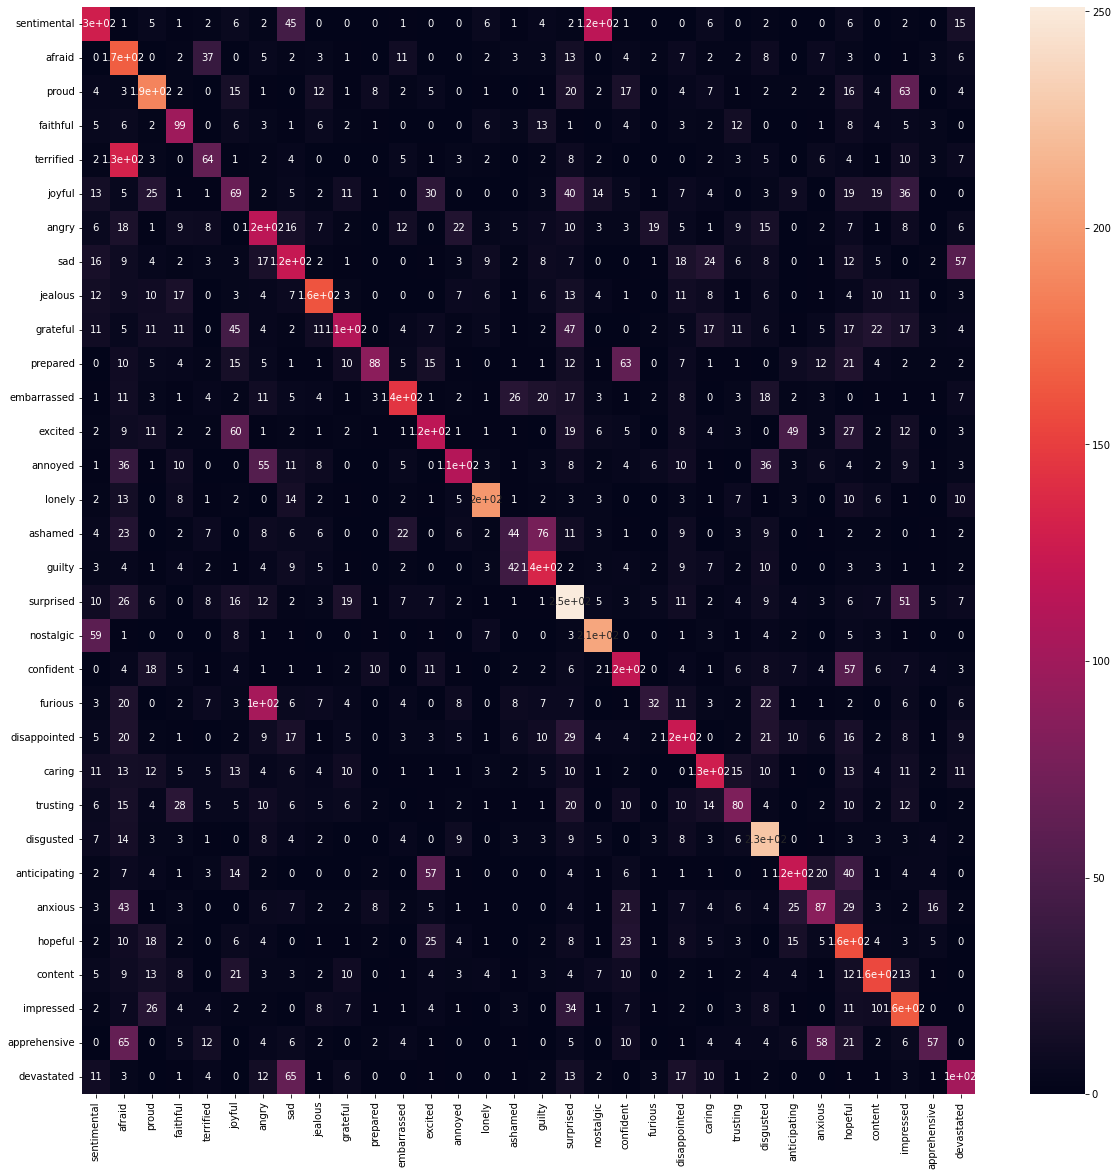

In [ ]:
class_names = list(integer_to_label.values())

fig, ax = plt.subplots(figsize=(20, 20))
heatmap = sns.heatmap(model3_large_cm, annot=True, xticklabels=class_names, yticklabels=class_names)

plt.show()

